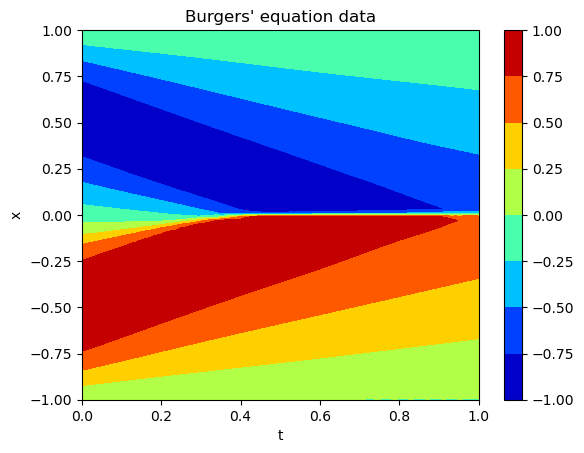

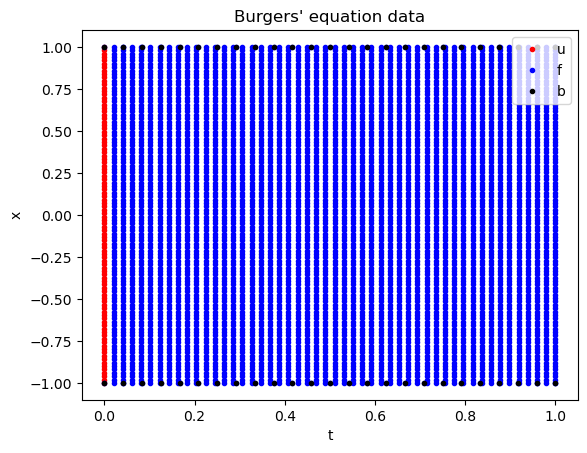

tensor([[0.0075],
        [0.0675],
        [0.1274],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], dtype=torch.float64, requires_grad=True)

In [21]:
import numpy as np

data = np.loadtxt("burgers.txt")
x = data[:, 0]
t = data[:, 1]
y = data[:, 2]

import matplotlib.pyplot as plt

plt.tricontourf(t, x, y, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers' equation data")
plt.show()

data_u = data[:100, :]
data_f = data[100:, :]

data_b = data[-50:, :]

plt.plot(data_u[:, 1], data_u[:, 0], ".r", label="u")
plt.plot(data_f[:, 1], data_f[:, 0], ".b", label="f")
plt.plot(data_b[:, 1], data_b[:, 0], ".k", label="b")
plt.legend()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers' equation data")
plt.show()

import torch

x_u = torch.tensor(data_u[:, 0], dtype=torch.double)
x_u = torch.cat(
    [x_u, torch.tensor(data_b[:, 0], dtype=torch.double)]
)  # add boundary points
x_f = torch.tensor(data_f[:, 0], dtype=torch.double)

t_u = torch.tensor(data_u[:, 1], dtype=torch.double)
t_u = torch.cat(
    [t_u, torch.tensor(data_b[:, 1], dtype=torch.double)]
)  # add boundary points
t_f = torch.tensor(data_f[:, 1], dtype=torch.double)

y_u = torch.tensor(data_u[:, 2], dtype=torch.double)
y_u = torch.cat(
    [y_u, torch.tensor(data_b[:, 2], dtype=torch.double)]
)  # add boundary points
y_f = torch.tensor(data_f[:, 2], dtype=torch.double)

x_u = x_u.reshape(-1, 1)
t_u = t_u.reshape(-1, 1)
u_u = y_u.reshape(-1, 1)

x_f = x_f.reshape(-1, 1)
t_f = t_f.reshape(-1, 1)
u_f = y_f.reshape(-1, 1)

x_u.requires_grad_(True)
t_u.requires_grad_(True)
u_u.requires_grad_(True)

x_f.requires_grad_(True)
t_f.requires_grad_(True)
u_f.requires_grad_(True)

In [22]:
print(data[-52:-48, 2])

[-0.01784043 -0.00162628  0.          0.        ]


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# burgers equation:
# u_t + u*u_x - (0.01/pi)*u_xx = 0
# x in [-1, 1], t in [0, 1]
# u(0, x) = -sin(pi*x)
# u(t, -1) = u(t, 1) = 0


class IPINN(nn.Module):
    def __init__(
        self, input_size=2, hidden_size=20, num_hidden_layers=8, output_size=1
    ):
        super(IPINN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

        self.lambda_1 = nn.Parameter(torch.tensor(0.9, dtype=torch.double))
        self.lambda_2 = nn.Parameter(torch.tensor(0.003, dtype=torch.double))

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        return self.model(inputs)


model = IPINN().double()


# N_u = 100
# N_f = 10000

# x_u = torch.rand(N_u, 1).double() * 2 - 1
# t_u = torch.zeros(N_u, 1).double()
# u_u = -torch.sin(np.pi * x_u)

# u_u.requires_grad_(True)


# t_bounts = [0, 1]
# x_bounds = [-1, 1]
# sampler = qmc.LatinHypercube(d=2)
# samples = sampler.random(n=N_f)
# t_f = samples[:, 0].reshape(-1, 1) * (t_bounts[1] - t_bounts[0]) + t_bounts[0]
# x_f = samples[:, 1].reshape(-1, 1) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]

# t_f = torch.tensor(t_f, requires_grad=True).double()
# x_f = torch.tensor(x_f, requires_grad=True).double()

# # t_f.requires_grad_(True)
# # x_f.requires_grad_(True)
# t_u.requires_grad_(True)
# x_u.requires_grad_(True)


def residual(model, t, x):
    #     t.requires_grad_(True)
    #     x.requires_grad_(True)
    u = model(t, x)
    u_t = torch.autograd.grad(
        u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    u_x = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]
    f = u_t + model.lambda_1 * u * u_x - model.lambda_2 * u_xx
    return f


gamma = 1e1


def loss_function(model, t_u, x_u, u_u, t_f, x_f, u_f):
    u_pred = model(t_u, x_u)
    mse_u = torch.mean((u_pred - u_u) ** 2)
    f_pred = residual(model, t_f, x_f)
    mse_f = torch.mean(f_pred**2)
    pred_f = model(t_f, x_f)
    mse_f2 = torch.mean((pred_f - u_f) ** 2)
    mse_f = mse_f + mse_f2 * gamma
    return mse_u + mse_f


optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1e0,
    line_search_fn="strong_wolfe",
    max_iter=300,
    max_eval=None,
    tolerance_grad=1e-8,
    tolerance_change=1e-10,
)


def closure():
    optimizer.zero_grad()
    loss = loss_function(model, t_u, x_u, u_u, t_f, x_f, u_f)
    loss.backward(retain_graph=True)
    return loss

In [31]:
for epoch in range(10):
    optimizer.step(closure)
    optimizer.zero_grad()
    loss = loss_function(model, t_u, x_u, u_u, t_f, x_f, u_f)
    print(f"Epoch {epoch}, Loss {loss.item()}")

Epoch 0, Loss 0.07420473191728474
Epoch 1, Loss 0.01897939062291347
Epoch 2, Loss 0.007110147783124706
Epoch 3, Loss 0.004262390237597744
Epoch 4, Loss 0.0025623909526645144
Epoch 5, Loss 0.0016958759623331044
Epoch 6, Loss 0.0010309051461599409
Epoch 7, Loss 0.0007101262012627756
Epoch 8, Loss 0.0005047913871445778
Epoch 9, Loss 0.00038209971278681254


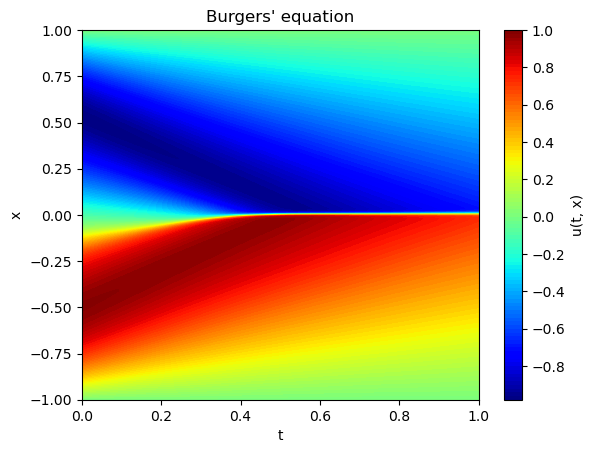

In [32]:
t_vals = torch.linspace(0, 1, 100).reshape(-1, 1).double()
x_vals = torch.linspace(-1, 1, 256).reshape(-1, 1).double()
t_grid, x_grid = torch.meshgrid(t_vals.flatten(), x_vals.flatten())
t_grid = t_grid.contiguous().reshape(-1, 1)
x_grid = x_grid.contiguous().reshape(-1, 1)

u_pred = model(t_grid, x_grid).detach().numpy()
u_pred = u_pred.reshape(100, 256)

import matplotlib.pyplot as plt

plt.figure()
plt.contourf(
    t_vals.flatten().numpy(), x_vals.flatten().numpy(), u_pred.T, 100, cmap="jet"
)
plt.colorbar(label="u(t, x)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers' equation")
plt.show()

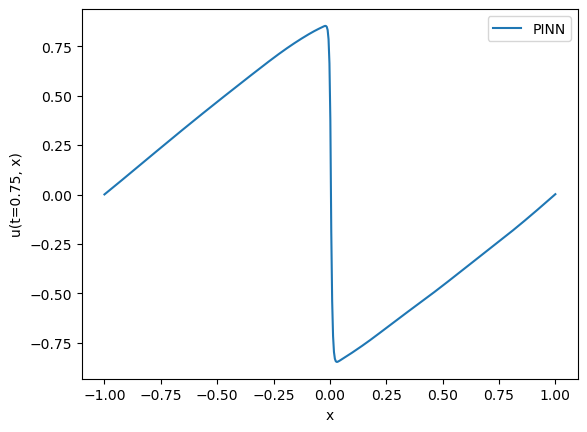

In [33]:
# import mpmath as mp
t_fixed = 0.75
x_fine = torch.linspace(-1, 1, 500, requires_grad=True).reshape(-1, 1).double()
t_fixed_tensor = torch.full_like(x_fine, t_fixed, requires_grad=True)
u_pred = model(t_fixed_tensor, x_fine).detach().numpy()

plt.figure()
plt.plot(x_fine.detach().numpy(), u_pred, label="PINN")
plt.xlabel("x")
plt.ylabel("u(t=0.75, x)")
plt.legend()
plt.show()

In [34]:
print("Learned Lambda 1:", model.lambda_1.item(), "True Lambda 1:", 1)
print("Learned Lambda 2:", model.lambda_2.item(), "True Lambda 2:", 0.01 / np.pi)

print("Difference of 1: ", model.lambda_1.item() - 1)
print("Difference of 2: ", model.lambda_2.item() - 0.01 / np.pi)

print("Error lambda 1:", (model.lambda_1.item() - 1) / 1, "%")
print("Error lambda 2:", (model.lambda_2.item() - 0.01 / np.pi) / (0.01 / np.pi), "%")

Learned Lambda 1: 0.9971859586479883 True Lambda 1: 1
Learned Lambda 2: 0.0034262191800754262 True Lambda 2: 0.003183098861837907
Difference of 1:  -0.002814041352011687
Difference of 2:  0.00024312031823751912
Error lambda 1: -0.002814041352011687 %
Error lambda 2: 0.07637850057134025 %
